<a href="https://colab.research.google.com/github/Matancoo/IML.HUJI/blob/main/challenge/DATA_CHALLENGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import pickle
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans, MiniBatchKMeans

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

# from kmodes.kprototypes import KPrototypes
!pip install kmodes
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

import torch
import torchvision
import torchvision.transforms as transforms
import random 
from torchvision import transforms, datasets
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:



def load_data(filename: str):
    """
    Load Agoda booking cancellation dataset
    Parameters
    ----------
    filename: str
        Path to house prices dataset
    Returns
    -------
    Design matrix and response vector in either of the following formats:
    1) Single dataframe with last column representing the response
    2) Tuple of pandas.DataFrame and Series
    3) Tuple of ndarray of shape (n_samples, n_features) and ndarray of shape (n_samples,)
    """
    # Data Preprocessing
    data = pd.read_csv(filename).drop_duplicates()

    # reformat the feature names:  

   
    #feature engineering before datetime conversion
    data['is_cancelled'] = (~pd.isna(data.cancellation_datetime)) #new response


    # creating one hot representation
    data = pd.get_dummies(data, columns=['charge_option'])
    # df= data[["hotel_country_code", 'is_cancelled']].groupby(["hotel_country_code"])['is_cancelled'].sum().reset_index()
    # data['hotel_country_code1'] = df['is_cancelled']
    

    # Changing dates to datetime type: 
    data['cancellation_datetime'] = pd.to_datetime(data['cancellation_datetime'])
    data['booking_datetime'] = pd.to_datetime(data['booking_datetime'])
    data['checkout_date'] = pd.to_datetime(data['checkout_date'])
    data['hotel_live_date'] = pd.to_datetime(data['hotel_live_date'])
    data['checkin_date'] = pd.to_datetime(data['checkin_date'])

    #feature engineering after datetime conversion
    data['time_interval'] = abs(data.booking_datetime.dt.day - data.checkin_date.dt.day).astype(int)


    data['booking_datetime_m'] = data.booking_datetime.dt.month.astype(int)
    data['booking_datetime_d']= data.booking_datetime.dt.day.astype(int)
    data['booking_datetime_y']= data.booking_datetime.dt.year.astype(int)
    data['checkin_date_m'] = data.checkin_date.dt.month.astype(int)
    data['checkin_date_d'] = data.checkin_date.dt.day.astype(int)
    data['checkin_date_y'] = data.checkin_date.dt.year.astype(int)
    # data['checkout_date_m'] = data.checkout_date.dt.month.astype(int)
    # data['checkout_date_d'] = data.checkout_date.dt.day.astype(int)
    # data['checkout_date_y'] = data.checkout_date.dt.year.astype(int)


    #nationalities --- take only relevant features

    # sample dropping
    
    # check that check-in is before the end_date
    end_date = pd.to_datetime('2018-12-13')
    data = data[data.checkin_date <= end_date]

    #feature dropping:
    # data.drop(columns=['origin_country_code','guest_nationality_country_name','hotel_area_code','accommadation_type_name','hotel_chain_code', 'booking_datetime', 'checkin_date','checkout_date','cancellation_datetime','hotel_id','h_booking_id','h_customer_id','hotel_brand_code','hotel_live_date','hotel_city_code','cancellation_policy_code','original_payment_currency','original_payment_type','original_payment_method','language','accommadation_type_name'],inplace=True)
    data.drop(columns=['hotel_area_code','hotel_brand_code','accommadation_type_name','hotel_chain_code', 'booking_datetime','checkout_date','checkin_date','cancellation_datetime','hotel_id','h_booking_id','h_customer_id','hotel_live_date','original_payment_currency','original_payment_type','language'],inplace=True)


#not final--> need to do k-prototype and further data featuring
    data.fillna(0, inplace = True)
    #TODO: need to deal with countries origin.

    #replaceing nan with 0

    data['request_nonesmoke'].replace(to_replace=np.nan, value = 0, inplace= True)
    data['request_nonesmoke'] = data['request_nonesmoke'].astype(int)
    data['request_latecheckin'].replace(to_replace=np.nan, value=0, inplace = True)
    data['request_latecheckin'] = data['request_latecheckin'].astype(int)
    data['request_highfloor'].replace(to_replace=np.nan, value=0, inplace = True)
    data['request_highfloor'] = data['request_highfloor'].astype(int)
    data['request_largebed'].replace(to_replace=np.nan, value=0, inplace = True)
    data['request_largebed'] = data['request_largebed'].astype(int)
    data['request_twinbeds'].replace(to_replace=np.nan, value=0, inplace = True)
    data['request_twinbeds'] = data['request_twinbeds'].astype(int)
    data['request_airport'].replace(to_replace=np.nan, value=0, inplace = True)
    data['request_airport'] = data['request_airport'].astype(int)
    data['request_earlycheckin'].replace(to_replace=np.nan, value=0, inplace = True)
    data['request_earlycheckin'] = data['request_earlycheckin'].astype(int)

    # data.cancellation_datetime = data['cancellation_datetime'].apply(lambda x: x.date())
    # start_date = pd.to_datetime('2018-12-07')
    # end_date = pd.to_datetime('2018-12-13')
    # df['cancellation_datetime'] = (df.cancellation_datetime <= end_date) &  (df.cancellation_datetime > start_date)

    data[['is_user_logged_in','hotel_star_rating','original_selling_amount','is_first_booking','is_cancelled']] = data[['is_user_logged_in','hotel_star_rating','original_selling_amount','is_first_booking','is_cancelled']].astype(int)



    # Dropping outliers
    # Dropping samples that have a checkin-date after 2018-12-13

    return data





def evaluate_and_export(estimator, X: np.ndarray, filename: str):
    """
    Export to specified file the prediction results of given estimator on given testset.
    File saved is in csv format with a single column named 'predicted_values' and n_samples rows containing
    predicted values.
    Parameters
    ----------
    estimator: BaseEstimator or any object implementing predict() method as in BaseEstimator (for example sklearn)
        Fitted estimator to use for prediction
    X: ndarray of shape (n_samples, n_features)
        Test design matrix to predict its responses
    filename:
        path to store file at
    """
    pd.DataFrame(estimator.predict(X), columns=["predicted_values"]).to_csv(filename, index=False)




Data Preprocessing

In [45]:
data.hotel_area_code

0        1192
1        5617
2        3819
3        2379
4        1506
         ... 
58654     995
58655     674
58656    3823
58657    4663
58658    3023
Name: hotel_area_code, Length: 58659, dtype: int64

In [3]:
#loading data:
data  = load_data('https://raw.githubusercontent.com/Matancoo/IML.HUJI/main/datasets/agoda_cancellation_train.csv')
response = data.pop('is_cancelled')
numeric_data = data.select_dtypes(exclude = 'object')

categorical_data = data.select_dtypes(include='object')
categorical_data = pd.get_dummies(categorical_data)


#scaling data before using kmeans -- may use othe rrobust scalers as alternative
# features = data[["col1", "col2", "col3", "col4"]]
# autoscaler = StandardScaler()
# features = autoscaler.fit_transform(features)
# features = features.apply(lambda x: autoscaler.fit_transform(x))



In [22]:
# visualize cancellation basded on hotel country location

# df= data[["hotel_country_code", 'is_cancelled']].groupby(["hotel_country_code"])['is_cancelled'].sum().reset_index()
# px.bar(df,x="hotel_country_code",y='is_cancelled')



hotel_country_code               object
hotel_star_rating                 int64
customer_nationality             object
guest_is_not_the_customer         int64
no_of_adults                      int64
no_of_children                    int64
no_of_extra_bed                   int64
no_of_room                        int64
original_selling_amount           int64
is_user_logged_in                 int64
is_first_booking                  int64
request_nonesmoke                 int64
request_latecheckin               int64
request_highfloor                 int64
request_largebed                  int64
request_twinbeds                  int64
request_airport                   int64
request_earlycheckin              int64
charge_option_Pay Later           uint8
charge_option_Pay Now             uint8
charge_option_Pay at Check-in     uint8
time_interval                     int64
booking_datetime_m                int64
booking_datetime_d                int64
booking_datetime_y                int64


In [5]:
#visualize cancellation basded on clients country location

# df= data[["customer_nationality", 'is_cancelled']].groupby(['customer_nationality'])['is_cancelled'].sum().reset_index()
# px.bar(df,x="customer_nationality",y='is_cancelled')

In [6]:
#visualizing time interval and booking cancellation

# x = data[['time_interval', 'is_cancelled']]
# px.bar(x,x='is_cancelled',y='time_interval')

#strategy: 
#1-convert all to numerical data and use k means.  
#2- separate the data and calculate kmodes and k means separately
#3- use k-prototypes - -note sure allowed since only kmeans is in sklearn database

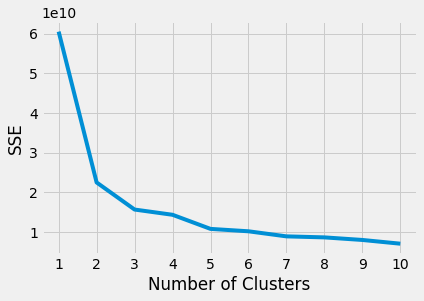

In [4]:
#1)

#Kmeans for numerical data:
# Creating a loop to try our different number of clusters: 

#finding best clusters number -- #elbow at cluster = 3

loss = []
for k in range(1, 11):
  kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=100, batch_size=1024)
  kmeans.fit(numeric_data)
  loss.append(kmeans.inertia_)


plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), loss)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [7]:
#creating clusters -- update n_clusters based on graph above
kmean =  MiniBatchKMeans(n_clusters=5,init='k-means++', max_iter=100, batch_size=1024)
clusters = kmean.fit_predict(numeric_data)
data['clusters'] = clusters
# Renaming the clusters:
# data['clusters'] = data['clusters'].map({0:'The Family', 1:'The Return Customer', 2:'The Cancellation Squad', 3:'The Extended Stay'})

# data.groupby(data['clusters']).describe(include='all').T
data = pd.get_dummies(data, columns=['clusters'])
data.drop(columns=data.select_dtypes(include='object').columns, inplace = True)


In [9]:
# 3) K-prototype

#NEED TO WORK ON THAT (doesnt work on categorical features)

# kproto = KPrototypes(n_clusters=4, init='Huang', verbose=0)
# clusters = kproto.fit_predict(data, categorical=[0,1,7,8,9,10,11,12,13,14,15])


In [10]:

#returns a correlation matrix of each feature with all others.

# # data = df.select_dtypes(include=np.number)  # select only numerical features
# corr_matrix = data.corr(method='pearson').loc[:, ['is_cancelled']].sort_values('is_cancelled')
# corr_target = abs(corr_matrix)






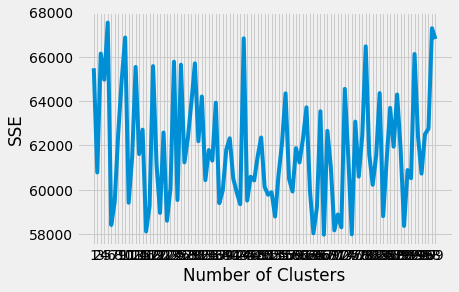

In [ ]:
#NN_MODEL


import torch.utils.data as data_utils

X_train, X_test, y_train, y_test = train_test_split(data, response)
BATCH_SIZE = 256

# Scaling the data

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_train.shape
# y_train = y_train[:,None]
# y_test = y_test[:,None]




# Creating our model's structure
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(37,)))
model.add(Dropout(0.18))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='bce',
              optimizer='adam',
              metrics=['binary_accuracy'])

# Fitting the model
history = model.fit(X_train,
                    y_train, 
                    batch_size = BATCH_SIZE,
                    validation_data =(X_test, y_test),
                    epochs = 100,
                    verbose = 0,)








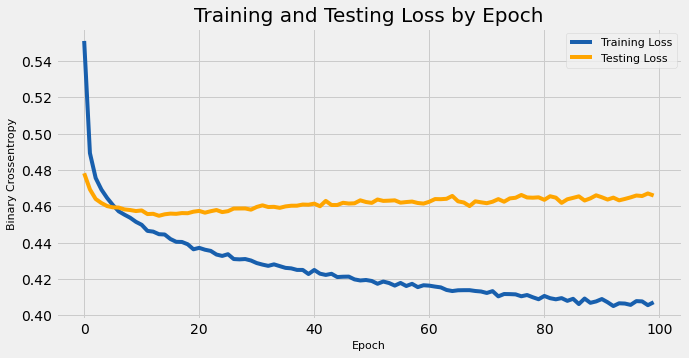

In [13]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Visualizing our training and testing loss by epoch
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 11)
plt.ylabel('Binary Crossentropy', fontsize = 11)
plt.legend(fontsize = 11);

# Credit to GA CNN global lecture author for the graph code 

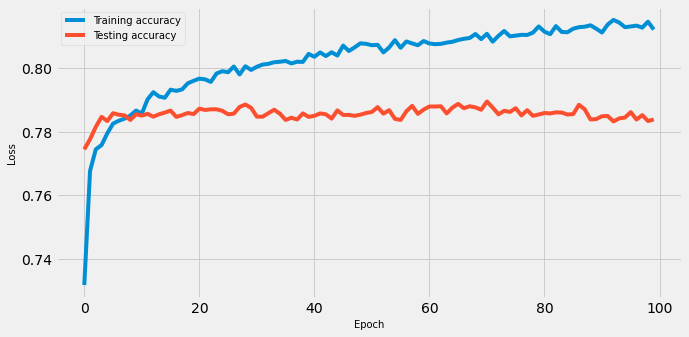

In [14]:
# Visualizing our training and testing accuracy.
plt.figure(figsize=(10, 5))
plt.plot(history.history['binary_accuracy'], label='Training accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Testing accuracy')
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend(fontsize = 10);

In [14]:

# if __name__ == '__main__':
#     np.random.seed(0)

#     # Load data
#     df, cancellation_labels = load_data("../datasets/agoda_cancellation_train.csv")
#     train_X, train_y, test_X, test_y = split_train_test(df, cancellation_labels)

#     # Fit model over data
#     estimator = AgodaCancellationEstimator().fit(train_X, train_y)

#     # Store model predictions over test set
#     evaluate_and_export(estimator, test_X, "id1_id2_id3.csv")